In [1]:
import pandas as pd
import os
import re
from imblearn.over_sampling import ADASYN
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from wordcloud import WordCloud
import matplotlib.pyplot as plt
from sklearn.decomposition import LatentDirichletAllocation

In [2]:
# Membaca dataset dengan pengecekan encoding
df = pd.read_csv('data/origin-data/google-play-rev-gen-2.csv', encoding='utf-8')

# Memeriksa beberapa baris pertama
df.head(10)

,id,title,avatar,rating,snippet,likes,date,iso_date,response
0,e5384431-56f9-43fa-a32a-53296afc7f66,Seraphim,https://play-lh.googleusercontent.com/a-/ALV-U...,3.0,"While I've reviewed this before, I decided to ...",88,"October 09, 2024",2024-10-09T00:08:20Z,NaN
1,6a73081f-3490-47ba-89fa-83744cb20940,TWOSTORE !,https://play-lh.googleusercontent.com/a-/ALV-U...,3.0,Very fun but I wish there was more fighting in...,35,"October 12, 2024",2024-10-12T06:39:01Z,NaN
2,3a3d4c90-0b6e-45dc-b1e6-014659055bbf,A G,https://play-lh.googleusercontent.com/a-/ALV-U...,3.0,"Fun game, I enjoy the story. There is tons to ...",11,"October 30, 2024",2024-10-30T18:01:37Z,NaN
3,99015538-1d26-4bd9-a02f-37bc2a361d1a,Astra,https://play-lh.googleusercontent.com/a-/ALV-U...,5.0,This game is phenomenal. The art style and sce...,77,"October 18, 2024",2024-10-18T19:11:12Z,NaN
4,541b3b4d-97f6-42e0-9c68-059a63e1e67f,Angela Williams,https://play-lh.googleusercontent.com/a-/ALV-U...,2.0,"I love this game. However, it is incredibly la...",14,"October 14, 2024",2024-10-14T03:04:43Z,NaN
5,ad484b6a-1b9c-42ab-9cee-9df6e28f12d4,Valerie,https://play-lh.googleusercontent.com/a-/ALV-U...,3.0,I used to be obsessed with this game but I hav...,99,"October 13, 2024",2024-10-13T14:02:08Z,NaN
6,fb25cdf6-40d8-44e8-b1b9-d439ebd88565,Daniel “Chotara” Ricciardi,https://play-lh.googleusercontent.com/a-/ALV-U...,5.0,Highly recommend. I have been playing the game...,65,"October 18, 2024",2024-10-18T15:20:11Z,NaN
7,36e821d3-9441-4eaa-94a7-9c7b9b7463b5,Amy,https://play-lh.googleusercontent.com/a-/ALV-U...,4.0,Hello! I absolutely love this game! It has inc...,29,"October 29, 2024",2024-10-29T00:27:08Z,NaN
8,4b1e6dcb-d251-450e-9be6-358b4bb8e9d6,Feitan Desy,https://play-lh.googleusercontent.com/a-/ALV-U...,4.0,I've been playing this game since January 16th...,64,"October 08, 2024",2024-10-08T23:13:09Z,NaN
9,27525772-1c0a-40e4-8321-4c5f0a0f7c64,Olivia Staringer,https://play-lh.googleusercontent.com/a-/ALV-U...,1.0,"Uninteresting characters, uninteresting dialog...",14,"November 11, 2024",2024-11-11T22:58:07Z,NaN


In [3]:
df = df.drop(columns=['id', 'title', 'avatar', 'date', 'iso_date', 'response'])

In [4]:
# Define the function to classify ratings
def classify_rating(rating):
    if rating in [3, 4, 5]:
        return 'positive'
    elif rating in [1, 2]:
        return 'negative'
    return 'unknown'

# Apply the classification function to create the 'rating_label' column
df['rating_label'] = df['rating'].apply(classify_rating)

# Pisahkan data ke dalam kelas positive dan negative
positive_data = df[df['rating_label'] == 'positive']
negative_data = df[df['rating_label'] == 'negative']

In [5]:
# Fungsi untuk pembersihan teks
def clean_text(text):
    # Menghapus URL
    text = re.sub(r'http\S+', '', text)
    # Menghapus emoji
    text = text.encode('ascii', 'ignore').decode('ascii')
    # Menghapus karakter non-alfabet
    text = re.sub(r'[^a-zA-Z\s]', '', text)
    # Mengubah teks menjadi huruf kecil
    text = text.lower()
    # Menghapus spasi berlebih
    text = re.sub(r'\s+', ' ', text).strip()
    return text

# Terapkan pembersihan teks pada kolom review
df['cleaned_snippet'] = df['snippet'].apply(clean_text)

In [6]:
# Pisahkan data menjadi fitur (X) dan target (y)
X = df['cleaned_snippet']  # Gunakan teks yang sudah dibersihkan
y = df['rating_label']

# Pisahkan data menjadi training dan testing (80:20)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Vektorisasi teks dengan TfidfVectorizer
vectorizer = TfidfVectorizer(stop_words='english', max_features=5000)
X_train_vec = vectorizer.fit_transform(X_train)

# Terapkan ADASYN untuk menambah data sintetis pada kelas minoritas (negative)
adasyn = ADASYN(sampling_strategy='minority', random_state=42, n_neighbors=5)
X_resampled, y_resampled = adasyn.fit_resample(X_train_vec, y_train)

# Convert kembali hasil resampling ke dalam DataFrame
# Proses pembersihan pada data sintetis
resampled_reviews = vectorizer.inverse_transform(X_resampled)  # Mengonversi kembali ke teks
resampled_reviews_cleaned = [clean_text(' '.join(review)) for review in resampled_reviews]  # Pembersihan teks

# Buat DataFrame untuk data sintetis yang telah dibersihkan
df_resampled = pd.DataFrame({
    'review': resampled_reviews_cleaned,  # Menggunakan data yang telah dibersihkan
    'rating_label': y_resampled
})

# Gabungkan data asli dengan data sintetis
df_balanced = pd.concat([df, df_resampled], ignore_index=True)

# Tampilkan jumlah data setelah augmentasi
print("\nJumlah data setelah ADASYN augmentasi:")
print(df_balanced['rating_label'].value_counts())

# Simpan dataset seimbang ke file baru
output_directory = 'data/new-changedData'
os.makedirs(output_directory, exist_ok=True)
balanced_output_file_path = os.path.join(output_directory, 'balanced-google-play-rev-gen-2.csv')
df_balanced.to_csv(balanced_output_file_path, index=False)
print(f"File balanced dataset saved to: {balanced_output_file_path}")


Jumlah data setelah ADASYN augmentasi:
rating_label
positive    279
negative    169
Name: count, dtype: int64
File balanced dataset saved to: data/new-changedData/balanced-google-play-rev-gen-2.csv


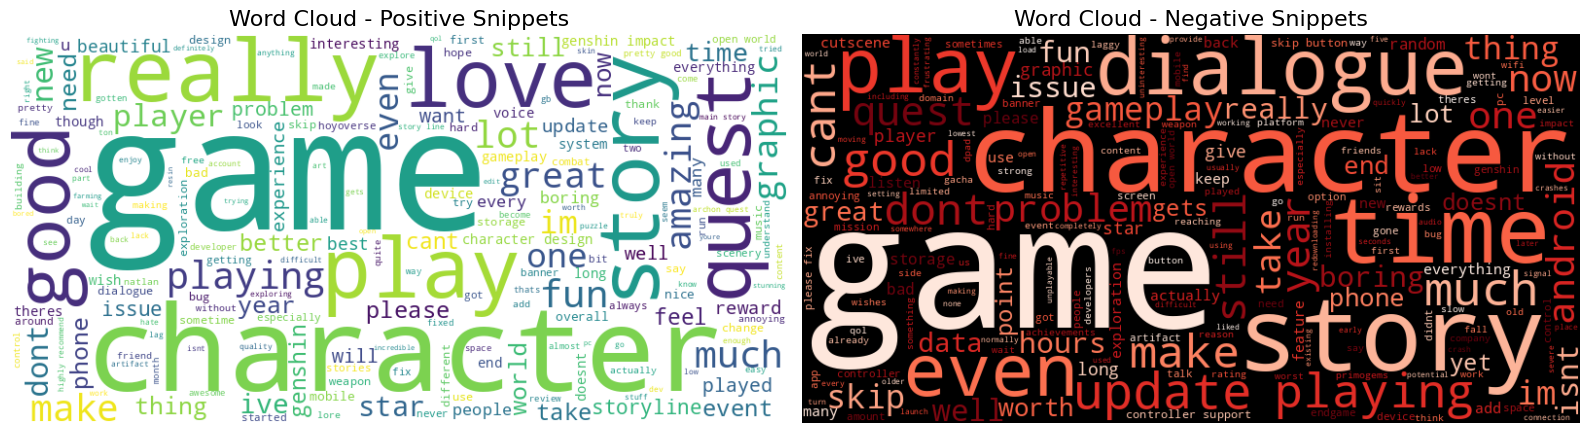

In [7]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud

# Load the dataset
df = pd.read_csv('data/new-changedData/balanced-google-play-rev-gen-2.csv', encoding='utf-8')

# Filter positive and negative snippets
positive_snippets = df[df['rating_label'] == 'positive']['cleaned_snippet']
negative_snippets = df[df['rating_label'] == 'negative']['cleaned_snippet']

# Combine all positive and negative snippets into single strings
positive_text = " ".join(positive_snippets.dropna())
negative_text = " ".join(negative_snippets.dropna())

# Generate word clouds for positive and negative snippets
wordcloud_positive = WordCloud(width=800, height=400, background_color='white').generate(positive_text)
wordcloud_negative = WordCloud(width=800, height=400, background_color='black', colormap='Reds').generate(negative_text)

# Create a subplot for word clouds
fig, ax = plt.subplots(1, 2, figsize=(16, 8))
ax[0].imshow(wordcloud_positive, interpolation='bilinear')
ax[0].set_title('Word Cloud - Positive Snippets', fontsize=16)
ax[0].axis('off')

ax[1].imshow(wordcloud_negative, interpolation='bilinear')
ax[1].set_title('Word Cloud - Negative Snippets', fontsize=16)
ax[1].axis('off')

plt.tight_layout()
plt.show()

In [10]:
from sklearn.feature_extraction.text import ENGLISH_STOP_WORDS
from collections import Counter


# Hitung frekuensi kata tanpa stopwords
positive_word_counts = Counter(" ".join(positive_snippets.dropna()).split())
negative_word_counts = Counter(" ".join(negative_snippets.dropna()).split())

# Menghapus stopwords dari hasil
filtered_positive_counts = {word: count for word, count in positive_word_counts.items() if word not in ENGLISH_STOP_WORDS}
filtered_negative_counts = {word: count for word, count in negative_word_counts.items() if word not in ENGLISH_STOP_WORDS}

# Tampilkan 10 kata paling sering muncul setelah menghapus stopwords
print("Top 10 kata yang sering muncul pada ulasan positif (tanpa stopwords):")
print(sorted(filtered_positive_counts.items(), key=lambda x: x[1], reverse=True)[:10])

print("Top 10 kata yang sering muncul pada ulasan negatif (tanpa stopwords):")
print(sorted(filtered_negative_counts.items(), key=lambda x: x[1], reverse=True)[:10])

Top 10 kata yang sering muncul pada ulasan positif (tanpa stopwords):
[('game', 286), ('characters', 96), ('like', 91), ('story', 66), ('just', 56), ('really', 54), ('good', 53), ('play', 51), ('love', 49), ('playing', 45)]
Top 10 kata yang sering muncul pada ulasan negatif (tanpa stopwords):
[('game', 72), ('story', 20), ('characters', 17), ('just', 16), ('play', 15), ('playing', 13), ('like', 13), ('skip', 13), ('good', 13), ('time', 11)]


In [36]:
# Menampilkan jumlah fitur yang dihasilkan
print("Jumlah fitur dalam X_positive_vec:", X_positive_vec.shape[1])
print("Jumlah fitur dalam X_negative_vec:", X_negative_vec.shape[1])

Jumlah fitur dalam X_positive_vec: 1601
Jumlah fitur dalam X_negative_vec: 701


In [13]:
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.feature_extraction.text import TfidfVectorizer

# LDA untuk topic modeling pada ulasan positif dan negatif
lda_positive = LatentDirichletAllocation(n_components=1, random_state=42)
lda_negative = LatentDirichletAllocation(n_components=1, random_state=42)

# Vektorisasi teks untuk ulasan positif
vectorizer_positive = TfidfVectorizer(stop_words='english', max_features=5000)
X_positive_vec = vectorizer_positive.fit_transform(positive_snippets.dropna())

# Vektorisasi teks untuk ulasan negatif
vectorizer_negative = TfidfVectorizer(stop_words='english', max_features=5000)
X_negative_vec = vectorizer_negative.fit_transform(negative_snippets.dropna())

# Fit LDA model untuk positif dan negatif
lda_positive.fit(X_positive_vec)
lda_negative.fit(X_negative_vec)

# Mendapatkan daftar kata yang digunakan dalam vektorisasi untuk masing-masing dataset
terms_positive = vectorizer_positive.get_feature_names_out()
terms_negative = vectorizer_negative.get_feature_names_out()

# Tampilkan topik dari LDA untuk positif
print("\nTopik dalam ulasan positif:")
for index, topic in enumerate(lda_positive.components_):
    print(f"\nTopik {index + 1}:")
    top_indices = topic.argsort()[-min(100, len(topic)):]  # Batasi jumlah indeks yang diambil
    print([terms_positive[i] for i in top_indices])

# Tampilkan topik dari LDA untuk negatif
print("\nTopik dalam ulasan negatif:")
for index, topic in enumerate(lda_negative.components_):
    print(f"\nTopik {index + 1}:")
    top_indices = topic.argsort()[-min(100, len(topic)):]  # Batasi jumlah indeks yang diambil
    print([terms_negative[i] for i in top_indices])


Topik dalam ulasan positif:

Topik 1:
['started', 'lore', 'space', 'device', 'awesome', 'friends', 'got', 'hoyoverse', 'update', 'understand', 'scenery', 'bug', 'getting', 'use', 'feels', 'issues', 'fix', 'different', 'combat', 'stories', 'music', 'highly', 'art', 'especially', 'thing', 'stars', 'feel', 'makes', 'hope', 'storage', 'bad', 'issue', 'end', 'nice', 'hard', 'things', 'main', 'try', 'exploration', 'doesnt', 'overall', 'years', 'mobile', 'recommend', 'gameplay', 'skip', 'wish', 'star', 'interesting', 'theres', 'player', 'impact', 'want', 'open', 'boring', 'events', 'people', 'players', 'need', 'beautiful', 'voice', 'storyline', 'takes', 'rewards', 'played', 'experience', 'designs', 'best', 'problem', 'pretty', 'long', 'better', 'phone', 'games', 'quest', 'ive', 'make', 'time', 'new', 'dont', 'quests', 'graphics', 'im', 'world', 'great', 'lot', 'genshin', 'character', 'amazing', 'fun', 'playing', 'just', 'love', 'play', 'really', 'good', 'story', 'like', 'characters', 'game']

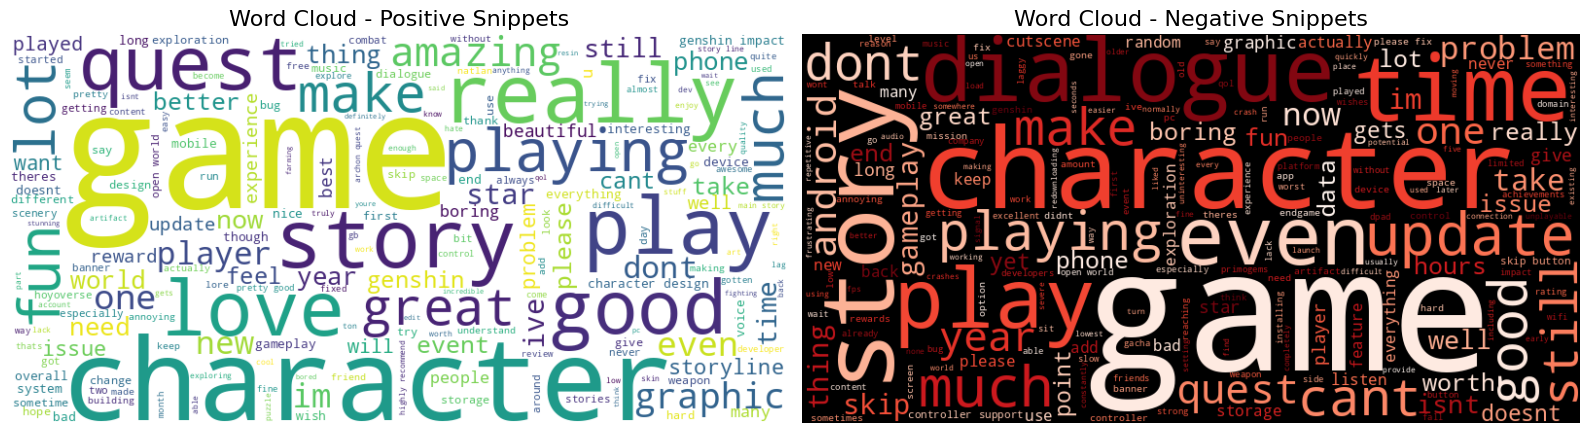

Top 10 kata yang sering muncul pada ulasan positif (tanpa stopwords):
[('game', 286), ('characters', 96), ('like', 91), ('story', 66), ('just', 56), ('really', 54), ('good', 53), ('play', 51), ('love', 49), ('playing', 45)]
Top 10 kata yang sering muncul pada ulasan negatif (tanpa stopwords):
[('game', 72), ('story', 20), ('characters', 17), ('just', 16), ('play', 15), ('playing', 13), ('like', 13), ('skip', 13), ('good', 13), ('time', 11)]

Topik dalam ulasan positif:

Topik 1:
['playing', 'just', 'love', 'play', 'really', 'good', 'story', 'like', 'characters', 'game']

Topik dalam ulasan negatif:

Topik 1:
['playing', 'good', 'android', 'like', 'skip', 'play', 'just', 'characters', 'story', 'game']


In [15]:
# Import library yang diperlukan
import pandas as pd
import matplotlib.pyplot as plt
from wordcloud import WordCloud
from collections import Counter
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

# Load dataset
try:
    df = pd.read_csv('data/new-changedData/balanced-google-play-rev-gen-2.csv', encoding='utf-8')
except FileNotFoundError:
    raise FileNotFoundError("Pastikan file 'balanced-google-play-rev-gen-2.csv' tersedia di jalur yang benar.")

# Pastikan kolom yang akan digunakan ada dalam data
assert 'cleaned_snippet' in df.columns, "Kolom 'cleaned_snippet' tidak ditemukan dalam data."
assert 'rating_label' in df.columns, "Kolom 'rating_label' tidak ditemukan dalam data."

# Filter ulasan positif dan negatif
positive_snippets = df[df['rating_label'] == 'positive']['cleaned_snippet']
negative_snippets = df[df['rating_label'] == 'negative']['cleaned_snippet']

# Gabungkan ulasan positif dan negatif menjadi satu string
positive_text = " ".join(positive_snippets.dropna())
negative_text = " ".join(negative_snippets.dropna())

# Buat WordCloud untuk ulasan positif dan negatif
wordcloud_positive = WordCloud(width=800, height=400, background_color='white').generate(positive_text)
wordcloud_negative = WordCloud(width=800, height=400, background_color='black', colormap='Reds').generate(negative_text)

# Tampilkan WordCloud
fig, ax = plt.subplots(1, 2, figsize=(16, 8))
ax[0].imshow(wordcloud_positive, interpolation='bilinear')
ax[0].set_title('Word Cloud - Positive Snippets', fontsize=16)
ax[0].axis('off')

ax[1].imshow(wordcloud_negative, interpolation='bilinear')
ax[1].set_title('Word Cloud - Negative Snippets', fontsize=16)
ax[1].axis('off')

plt.tight_layout()
plt.show()

# Hitung frekuensi kata tanpa stopwords
positive_word_counts = Counter(positive_text.split())
negative_word_counts = Counter(negative_text.split())

# Menghapus stopwords dari hasil
vectorizer = TfidfVectorizer(stop_words='english')
stop_words = set(vectorizer.get_stop_words())

filtered_positive_counts = {word: count for word, count in positive_word_counts.items() if word not in stop_words}
filtered_negative_counts = {word: count for word, count in negative_word_counts.items() if word not in stop_words}

# Menampilkan kata yang paling sering muncul setelah menghapus stopwords
print("Top 10 kata yang sering muncul pada ulasan positif (tanpa stopwords):")
print(sorted(filtered_positive_counts.items(), key=lambda x: x[1], reverse=True)[:10])

print("Top 10 kata yang sering muncul pada ulasan negatif (tanpa stopwords):")
print(sorted(filtered_negative_counts.items(), key=lambda x: x[1], reverse=True)[:10])

# LDA untuk topic modeling
lda_positive = LatentDirichletAllocation(n_components=1, random_state=42)
lda_negative = LatentDirichletAllocation(n_components=1, random_state=42)

# Vektorisasi teks
vectorizer_positive = TfidfVectorizer(stop_words='english', max_features=1601)  # Sesuai dengan jumlah fitur
vectorizer_negative = TfidfVectorizer(stop_words='english', max_features=701)   # Sesuai dengan jumlah fitur

X_positive_vec = vectorizer_positive.fit_transform(positive_snippets.dropna())
X_negative_vec = vectorizer_negative.fit_transform(negative_snippets.dropna())

# Fit LDA model
lda_positive.fit(X_positive_vec)
lda_negative.fit(X_negative_vec)

# Mendapatkan daftar kata yang digunakan dalam vektorisasi
terms_positive = vectorizer_positive.get_feature_names_out()
terms_negative = vectorizer_negative.get_feature_names_out()

# Menampilkan topik
print("\nTopik dalam ulasan positif:")
for index, topic in enumerate(lda_positive.components_):
    print(f"\nTopik {index + 1}:")
    top_indices = topic.argsort()[-10:]  # 10 kata teratas
    print([terms_positive[i] for i in top_indices if i < len(terms_positive)])  # Pastikan indeks sesuai

print("\nTopik dalam ulasan negatif:")
for index, topic in enumerate(lda_negative.components_):
    print(f"\nTopik {index + 1}:")
    top_indices = topic.argsort()[-10:]  # 10 kata teratas
    print([terms_negative[i] for i in top_indices if i < len(terms_negative)])  # Pastikan indeks sesuai
